In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
from scipy.stats import norm 
from scipy.stats import stats 

%matplotlib inline

# Задание 1: A/B тестирование / Task 1: A/B testing
### В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.
### During a hypothesis testing a new mechanic of payment has been introduced to the target group, and the control group had the usual mechanic. Your goal is to analyze the results of the experiment and find out, wether it is wise to launch the new payment mechanic for all users.

### В качестве входных данных Вы имеете 4 csv-файла / as input data you have 4 csv-files:

### groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) / a file that shows to which group a certain user belongs to (A - control group, B - target group)
### groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных / an additional file with users that you recieved two days after you sent the data
### active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. / a file with information about users that entered the platform during the experiment
### checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. / a file with information about user payments during the experiment

In [2]:
groups = pd.read_csv('~/my_final_project/variant_2/groups.csv', sep=';')

In [3]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [4]:
groups_add = pd.read_csv('~/my_final_project/variant_2/group_add.csv')
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [5]:
active_users = pd.read_csv('~/my_final_project/variant_2/active_studs.csv')
active_users = active_users.rename(columns={'student_id': 'id'})
active_users.head()

,id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [6]:
checks = pd.read_csv('~/my_final_project/variant_2/checks.csv', sep=';')
checks = checks.rename(columns={'student_id': 'id'})
print(checks.shape)
checks.head()

(541, 2)


,id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


### План подготовки данных перед тестированием / plan of prepearing data before testing:
1. Объединить groups с gropups_add, чтобы получить общий список пользователей, разделенный на группы / Unite "groups" with "groups_add" to ave a full dataframe of users, divided into groups
2. Объединить полученный датафрейм с active_users, чтобы получить список из активных пользователей по группам / Merge the dataframe from the previous step with "active_users" in order to get a dataframe with information about active users, divided into groups
3. Объединить полученный датафрейм с checks, чтобы получить список активных пользователей по группам с информацией, по которой можно оценить статистическую значимость внедренных изменений / Merge the dataframe from the last step with "checks" in order to get a dataframe of active users divided into groups with information, with which one can evaluate the statistical significance of introduced changes

In [7]:
# 1
full_groups = pd.concat([groups, groups_add], ignore_index=True)
print(f'Number of entries in "groups" = {groups.shape[0]}, number of entries in "groups_add" = {groups_add.shape[0]}, total number of entries = {groups.shape[0] + groups_add.shape[0]}')
print(f"Is the resulting DataFrame without duplicates? - {(groups.shape[0] + groups_add.shape[0]) == full_groups.drop_duplicates(subset=['id', 'grp']).shape[0]}")

Number of entries in "groups" = 74484, number of entries in "groups_add" = 92, total number of entries = 74576
Is the resulting DataFrame without duplicates? - True


In [8]:
# 2
active_groups = full_groups.merge(right=active_users, how='inner', on='id')
active_groups.head()

,id,grp
0,1627,A
1,2085,B
2,2215,B
3,3391,A
4,3401,B


In [9]:
# 3
df = active_groups.merge(right=checks, how='left', on='id')
df = df.fillna(0.0)
df.head()

,id,grp,rev
0,1627,A,990.0
1,2085,B,0.0
2,2215,B,0.0
3,3391,A,0.0
4,3401,B,0.0


## Поставленные гипотезы: первая группа / Introduced Hypothesis: first set:
### H0: Разницы в ARPPU (Average revenue per paying user) между контрольной и целевой группами нет / There is no significant difference between the control and target groups in the ARPPU (Average revenue per paying user)
### H1: Разница в ARPPU между контрольной и целевой группами есть / There is significant difference between the control and target groups in the ARPPU

### Шаг 1: Разделим полученные данные на на два датасета по типу группы, к оторой пренадлежат пользователи, причем не будем учитывать активных пользователей, которые не совершали покупок 
### Step 1: Let us divide given data into two datasets according to the user's group belonging, without data about active users that haven't made purchases

In [10]:
control = df.query('grp == "A" and rev != 0.0').rev.reset_index(drop=True)
target = df.query('grp == "B" and rev != 0.0').rev.reset_index(drop=True)
print(f'The size of the control group (A) is {control.shape[0]} \nThe size of the target group (B) is {target.shape[0]}')
control.head()

The size of the control group (A) is 78 
The size of the target group (B) is 314


0     990.0
1    1830.0
2    2910.0
3    2820.0
4    3660.0
Name: rev, dtype: float64

### Шаг 2: Проверка распределений на нормальность и значимое отличие в дисперсиях
### Step 2: Checking wether the distributions are normal and wether their variances differ significantly

In [11]:
import scipy

print(scipy.stats.levene(control, target)) 
# Дисперсии значимо отличаются / variances differ significantly

print(scipy.stats.normaltest(control)) 
# Распределение значимо отличается от нормального / Distribution differs from normal significantly

print(scipy.stats.normaltest(target)) 
# Распределение значимо отличается от нормального / Distribution differs from normal significantly

LeveneResult(statistic=3.075681699981606, pvalue=0.08025675761347022)
NormaltestResult(statistic=30.378419638487475, pvalue=2.5316868804220266e-07)
NormaltestResult(statistic=6.795662714490353, pvalue=0.033445723194625424)


### Дополнение: Так как согласно некоторым источникам (https://koch-kir.medium.com/история-одного-обмана-или-требования-к-распределению-в-статистических-тестах-55139a5558d) необходимо проверить на нормальность не само распределение метрики, а распределение средних этого распределения на нормальность, создадим функцию, которая выполнит это действие - my_normaltest
### Addition: Because of the fact that there are sources (https://koch-kir.medium.com/история-одного-обмана-или-требования-к-распределению-в-статистических-тестах-55139a5558d) that suggest that it is not the normality of the general distribution that has to be checked, rather the normality of the distribution of mean values of sub-distributions, let us create a function that will do just that - my_normaltest

In [12]:
def my_normaltest(
    data_column, # числовые значения выборки
    boot_it = 1000, # количество подвыборок
):
    data = [] # Список, в котором будет храниться распределение средних
    
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples = data_column.sample(
            len(data_column), 
            replace = True # параметр возвращения
        ).values
        
        data.append(np.mean(samples)) # mean() - применяем статистику
        
#     print(data)
    print(scipy.stats.shapiro(data))
    

In [13]:
my_normaltest(control)
my_normaltest(target)



ShapiroResult(statistic=0.9957589507102966, pvalue=0.007415601518005133)



ShapiroResult(statistic=0.9972440004348755, pvalue=0.08549245446920395)


### Шаг 3: Визуализируем полученные распределения через histplot и boxplot. Глядя на последний можно сделать предположение, что в результате проведения A/B теста различия между средними выборок окажутся значимыми и Н0 будет отвергнута (p<0.05)
### Step 3: Let us visualize the distributions via histplot and boxplot. Judging by the latter one can make an assumption that the difference between mean values of the distributions will be significant and H0 will be rejected (p<0.05)

[Text(0.5, 1.0, 'Control and target group comparison')]

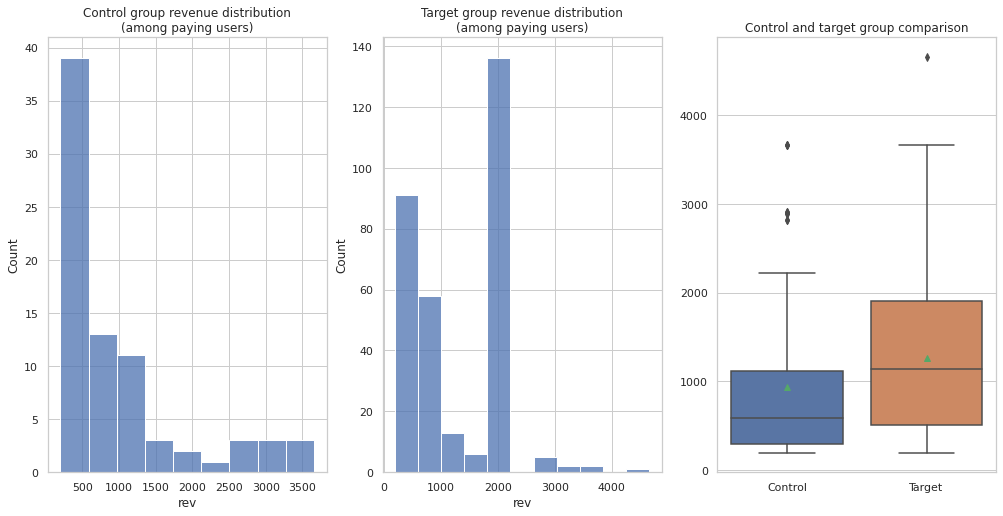

In [14]:
sns.set(
    font_scale=1,
    style="whitegrid",
    rc={'figure.figsize':(17,8)}
        )
fig, axes = plt.subplots(1, 3)
sns.histplot(data = control, ax=axes[0], label='control') \
    .set(title='Control group revenue distribution\n(among paying users)')
sns.histplot(data = target, ax=axes[1], label='target') \
    .set(title='Target group revenue distribution\n(among paying users)')
sns.boxplot(data = pd.DataFrame({'Control': control, 'Target': target}), ax=axes[2], showmeans=True) \
    .set(title='Control and target group comparison')

Видно, что медианное и среднее значения выборки группы Target выше, чем у Control. Этого говорит о том, что изменения скорее всего имеют положительный эффект

It is evident, that the median and mean values of the Target group are higher than the median and mean values of the Control group. This suggests that the introduced changes had a positive effect

### Шаг 4: Так как распределяемая величина является непрерывной, и условие для выполнения t-теста не соблюдено, остается выполнить непараметрический U-тест и Bootstrap, так как они работают непосредственно с предоставленными им данными, а не с теоретическими распределениями
### Step : Because the distributed metric is continuos and the condicion for t-test has not been met, let us use the unparametric U-test and Bootstrap, which work with the data itself, without theoretical distributions.

In [15]:
scipy.stats.mannwhitneyu(control, target)
# Согласно U-тесту, азличия между средними значениями значимы - Н0 отвергается
# According to the U-test the difference between distributions' means is significant - H0 is rejected

MannwhitneyuResult(statistic=9001.0, pvalue=0.0002511393831406922)

In [16]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

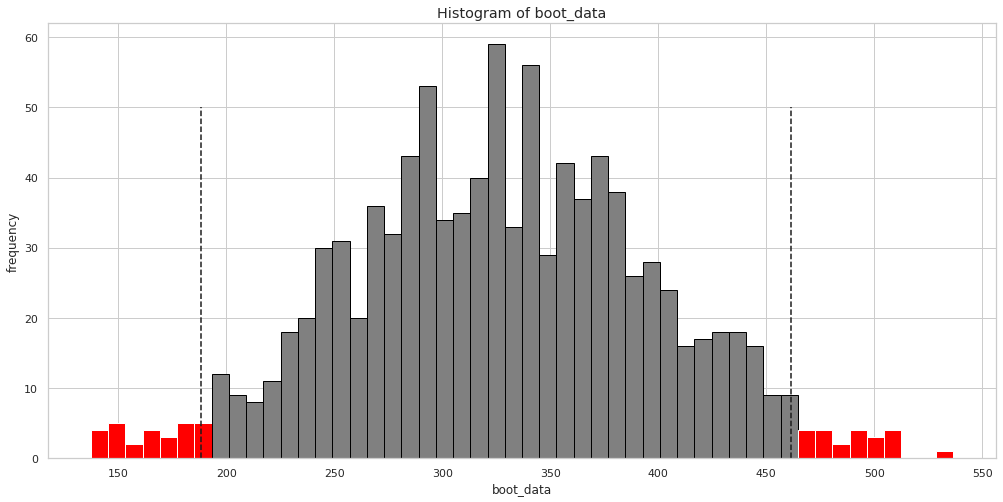

p-value: 3.2888313701384385e-06
                0
0.025  188.375409
0.975  461.449293


In [17]:
booted_data = get_bootstrap(target, control, boot_it = 1000)
print('p-value:', booted_data["p_value"])
print(booted_data["quants"] )
# Результат проведения Bootstrap подтверждает результаты U-теста - Н0 отвергается
# The results of Bootstrap confirm the reliability of U-test results - H0 is rejected

## Поставленные гипотезы: вторая группа / Introduced Hypothesis: second set:
### H0: Разницы в ARPU (Average revenue per user) между контрольной и целевой группами нет / There is no significant difference between the control and target groups in the ARPU (Average revenue per user)
### H1: Разница в ARPU между контрольной и целевой группами есть / There is significant difference between the control and target groups in the ARPU
### Воспользуемся тем же алгоритмом, что и при проверке первой группы гипотез / Let us use the same algorithm, that was used to test the first set of hypothesis

### 1. Создадим 2 датасета с пользователями, разделенными по группам / Create 2 datasets with users from each of the two groups

In [18]:
full_control = df.query('grp == "A"').rev.reset_index(drop=True)
full_target = df.query('grp == "B"').rev.reset_index(drop=True)
print(f'The size of the control group (A) is {full_control.shape[0]} \nThe size of the target group (B) is {full_target.shape[0]}')
full_control.head()

The size of the control group (A) is 1538 
The size of the target group (B) is 6803


0    990.0
1      0.0
2      0.0
3      0.0
4      0.0
Name: rev, dtype: float64

### 2. Проверим нормальность распределения параметра revenue / Check wether revenue distributions are normal

In [19]:
print(scipy.stats.levene(control, target)) 
# Дисперсии значимо отличаются / variances differ significantly
print(scipy.stats.normaltest(full_control))
# Распределение значимо отличается от нормального / Distribution differs from normal significantly
print(scipy.stats.normaltest(full_target))
# Распределение значимо отличается от нормального / Distribution differs from normal significantly

LeveneResult(statistic=3.075681699981606, pvalue=0.08025675761347022)
NormaltestResult(statistic=2240.595797407402, pvalue=0.0)
NormaltestResult(statistic=7797.399211581946, pvalue=0.0)


In [20]:
my_normaltest(full_target)


ShapiroResult(statistic=0.9990189671516418, pvalue=0.8827524185180664)


### 3. Визуализировать распределения / Visualise distributions

[Text(0.5, 1.0, 'Control and target group comparison')]

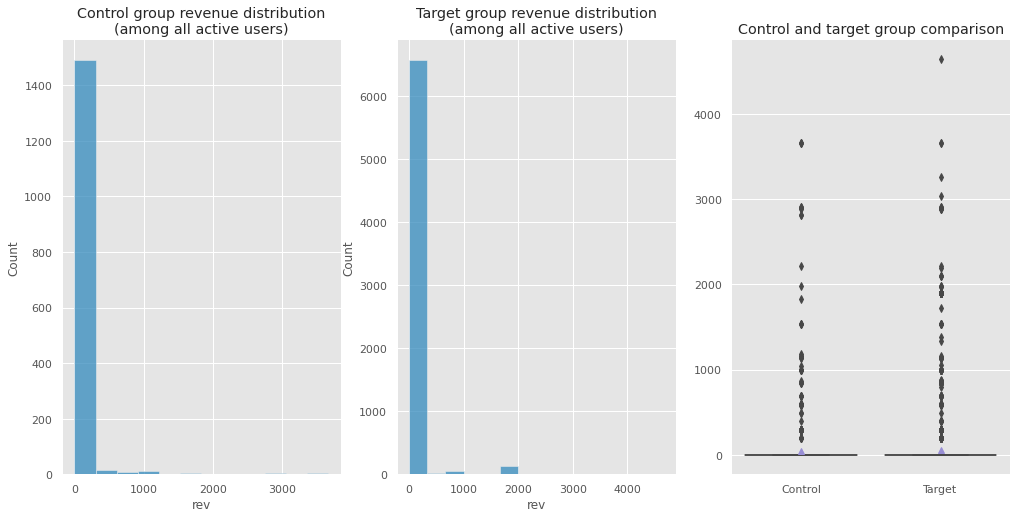

In [21]:
fig, axes = plt.subplots(1, 3)
sns.histplot(data = full_control, ax=axes[0], label='control') \
    .set(title='Control group revenue distribution\n(among all active users)')
sns.histplot(data = full_target, ax=axes[1], label='target') \
    .set(title='Target group revenue distribution\n(among all active users)')
sns.boxplot(data = pd.DataFrame({'Control': full_control, 'Target': full_target}), ax=axes[2], showmeans=True) \
    .set(title='Control and target group comparison')

### 4. Проведем U-тест и бутстрап / Conduct U-test and bootstrap

In [22]:
print(scipy.stats.mannwhitneyu(full_target, full_control))

MannwhitneyuResult(statistic=5210901.0, pvalue=0.5099747992861601)


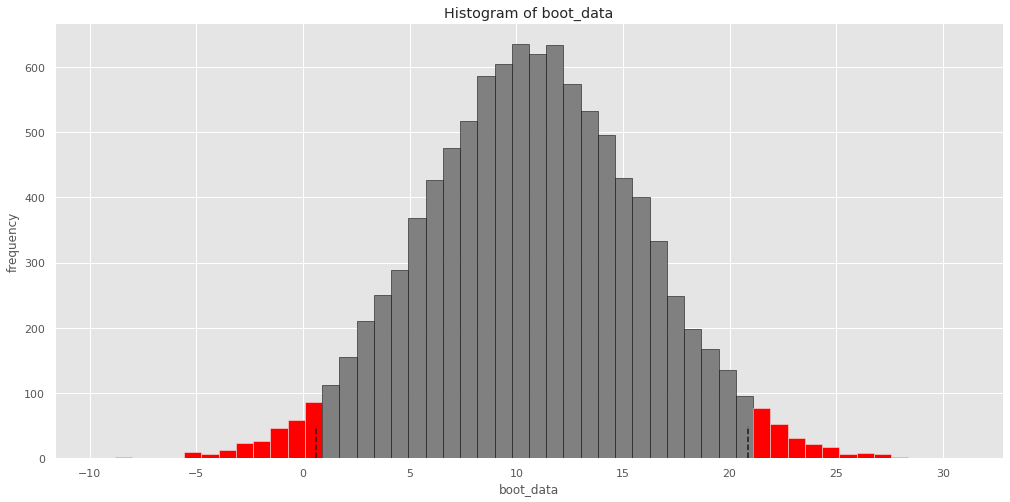

p-value: 0.03722835169743839
               0
0.025   0.627948
0.975  20.860452


In [23]:
full_booted_data = get_bootstrap(full_target, full_control, boot_it = 10000)
print('p-value:', full_booted_data["p_value"])
print(full_booted_data["quants"] )

### U-тест показывает, что разница между выборками статистически не значима (p>0.05), в то время как bootstrap показывает обратный результат (p<0.05). Для определения того, какому тесту довериться, вспомним результаты, полученные из предыдущего A/B-теста, где изменения оказались значимыми, а также вспомним, что U-тест построен на том, что данные переводят в ранг и далее смотрят на разницу между средними рангами первой и воторой групп. Данный метод менее чувствителен к выбросам, однако для полученного распределения эта чувствительность важна, так как в данном случае выбросы - не лишние значения, а просто значения, выделяющиеся на фоне большого количества данных, где revenue = 0. Таким образом, лучше довериться тесту, который более чувствителен к ним, а не менее. Из этого следует, что bootstrap более надежен, чем U-тест в данном случае, и что разница между ARPU статистически значима.

### U-test sows that the difference between distributions is not statistically significant (p>0.05), while bootstrap shows the opposite result (p<0.05). In order to determine, which result to trust let us remember the result of the previous A/B test, where the difference was statistically significant, but also one should remember that U-test is designed to turn data into ranks and compare mean values of rank between given distributions. Also, this test is known to be less sensitive to outliers, but in this case the outliers are not there by some mistake, they are just values that stand out in the background of entries, that have 0 revenue value, so we should trust a test, that is more sensitive to them, not less. This brings us to a conclusion that in this case bootstrap is more reliable than U-test and that the difference in ARPU is statistically significant after all.

## Поставленные гипотезы: третья группа / Introduced Hypothesis: third set:
### H0: Разницы в CR (Conversion rate) между контрольной и целевой группами нет / There is no significant difference between the control and target groups in the CR
### H1: Разница в CR между контрольной и целевой группами есть / There is significant difference between the control and target groups in the CR
### Воспользуемся тестом хи-квадрат, предварительно подготовив данные о сконвертировавшихся и несконвертировавшийся пользователях по обеим группам, оформив их в таблицу сопряженности.
### Let us use the chi-squared test by creating a R x C table with information about converted and not converted users by groups.

In [24]:
CR_table = pd.DataFrame({'converted': [control.shape[0], target.shape[0], control.shape[0] + target.shape[0]],
                         'not_converted': [full_control.shape[0] - control.shape[0], full_target.shape[0] - target.shape[0], full_control.shape[0] - control.shape[0] + full_target.shape[0] - target.shape[0]],
                        'both': [full_control.shape[0], full_target.shape[0], full_control.shape[0] + full_target.shape[0]]}, 
                       index=['control group', 'target group', 'both groups'])
CR_table

,converted,not_converted,both
control group,78,1460,1538
target group,314,6489,6803
both groups,392,7949,8341


### Проверим ожидаемые количества сконвертировавшихся пользователей в каждой группе за счет умножения количества пользователей в конкретной группе на вероятность конвертирования (количество сконвертировавшихся пользователей в обеих группах разделенное на общее количество пользователей в тесте)
### We can check the expected values of converted users in each group by multiplying the number of users in a group by the probability of conversion (number of converted users among both groups divided by the total number of users in a test )

In [25]:
expected_control = full_control.shape[0] * ((control.shape[0] + target.shape[0]) / (full_control.shape[0] + full_target.shape[0]))
expected_target = full_target.shape[0] * ((control.shape[0] + target.shape[0]) / (full_control.shape[0] + full_target.shape[0]))

print(expected_control)
print(expected_target)


72.28102146025657
319.71897853974343


### Проведем тест, отправив на вход функции версию таблицы сопряженности, где отстутствуют сложенные значения по группам ('both' и 'both groups'). Получившаяся таблица имеет размер 2х2, то есть количество степеней свободы равно 1. Полученное p-value составляет 0.48625240457231045 (> 0.05), ожидаемые количества сконвертировавшихся пользователей совпадают с расчетными. Это означает, что тест был проведен корректно, однако в его результате можно сделать вывод, что изменения в конверсии не являются статистически значимыми.
### Let us run the test by giving as function's input a version of the R x C table that does not have added values ('both' and 'both groups'). The resulting table's size is 2x2 which means that the number of degreees of freedom equals 1. The resulting p-value is 0.48625240457231045 (> 0.05), the expected values of converted users match the previously calculated ones. This means that the test has run correctly, but it also means that the difference in CR is not statistically significant.

In [26]:
scipy.stats.chi2_contingency(CR_table.loc['control group':'target group', 'converted':'not_converted'])

(0.48480826522557896,
 0.48625240457231045,
 1,
 array([[  72.28102146, 1465.71897854],
        [ 319.71897854, 6483.28102146]]))

## В дополнение к этому посчитаем метрики, которые сравнивали

In [27]:
arppu_control = round(control.sum() / control.shape[0], 2)
print(f'ARPPU for the control group is {arppu_control}')
arppu_target = round(target.sum() / target.shape[0], 2)
print(f'ARPPU for the target group is {arppu_target}')
print()
arpu_control = round(control.sum() / full_control.shape[0], 2)
print(f'ARPU for the control group is {arpu_control}')
arpu_target = round(target.sum() / full_target.shape[0], 2)
print(f'ARPU for the target group is {arpu_target}')
print()
CR_control = round((control.shape[0] / full_control.shape[0]) * 100, 2)
print(f'CR for the control group is {CR_control}%')
CR_target = round((target.shape[0] / full_target.shape[0]) * 100, 2)
print(f'CR for the target group is {CR_target}%')

ARPPU for the control group is 933.59
ARPPU for the target group is 1257.88

ARPU for the control group is 47.35
ARPU for the target group is 58.06

CR for the control group is 5.07%
CR for the target group is 4.62%


# Выводы:
### 1.В результате анализа данных, было выяснено, что распределяемые метрики (ARPPU и ARPU) не распределены нормально, что исключает использование t-теста для сравнения распределений, что привело к использованию не настолько же надежных методов (U-тест и Bootstrap). Также сам размер полученной для ARPPU выборки не является достаточно большим для формулировки уверенных выводов. Рекомендуется увеличить время тестирования для сбора большего объема данных
### 2. В результате проведения A/B тестов, можно сделать вывод, что различия между полученными данными для ARPPU и ARPU статистически значимы и нововведение положительно отразилось на них, однако изменения в CR оказались незначительными. Из этого можно сделать вывод, что за счет практически такого же количеств платящих пользователей компания стала больше зарабатывать. Можно распространить новую механику оплаты на всех пользователей.
### 3. Рекомендация: Для повышения надежности анализа следует выбрать дополнительные несколько показателей, по которым можно будет провести A/B тесты, и таким образом снизить вероятность неправильных выводов. 
### Примеры дополнительных метрик: частичная или полная конверсия по шагам оплаты услуг на сайте, сегментация пользователей по подходящему специфике продукта признаку (например, области, в которой была сделана покупка или статусу/возрасту покупателя)

# Conclusions:
### 1. After analyzing the given data, it was discovered that the distributed metrics (ARPPU and ARPU) were not normally distributed, which eliminated the possibility to conduct a t-test. As a result, less reliable methods of A/B-testing (U-test, Bootstrap) were used. Additionally, the sizes of resulting distributions for ARPPU were too small to make any concrete decisions, which is why it is recommended to expand the time of the experiment next time, in order to gather more data.
### 2. After completing A/B-tests, it was concluded that the difference between distributions for ARPPU and ARPU is statistically significant and the new mechanic of payment has positively reflected them, however the difference in CR has proved not to be statistically significant. This can mean that by retaining the same number of paying users, the company has increased the amount of profit. The new method can be expanded to be used by all users.
### 3. Recommendation: In order to increase the reliability of A/B-testing in the future, more parameters should be tracked and then transferred as input data. That can specify anomalies and decrease the probability of making incorrect conclusions
### Examples of additional parameters/metrics to track: partial or full conversion on different steps of payment process, user segmentation by a product-appropriate parameter (for example an area, where the purchase was made or the status/age of the user)